# Youtube Data Collection and Analysis with Python

Now, let's get started with Youtube data collection using Python. I'll collect data about the top 200 trending videos on Youtube:

In [4]:
import pandas as pd 
from googleapiclient.discovery import build

API_KEY = 'YOUR API KEY'

def get_trending_videos(api_key, max_results=200):
    #build the youtube service
    youtube = build('youtube', 'v3', developerKey=api_key)
    
    # initialize the list to hold video details
    videos = []
    
    # fetch the most popular videos
    request = youtube.videos().list(
        part='snippet, contentDetails, statistics',
        chart='mostPopular',
        regionCode='US',
        maxResults=50
    )
    
    # paginate through the results if max_results > 50
    while request and len(videos) < max_results:
        response = request.execute()
        for item in response['items']:
            video_details = {
                                'video_id': item['id'],
                'title': item['snippet']['title'],
                'description': item['snippet']['description'],
                'published_at': item['snippet']['publishedAt'],
                'channel_id': item['snippet']['channelId'],
                'channel_title': item['snippet']['channelTitle'],
                'category_id': item['snippet']['categoryId'],
                'tags': item['snippet'].get('tags', []),
                'duration': item['contentDetails']['duration'],
                'definition': item['contentDetails']['definition'],
                'caption': item['contentDetails'].get('caption', 'false'),
                'view_count': item['statistics'].get('viewCount', 0),
                'like_count': item['statistics'].get('likeCount', 0),
                'dislike_count': item['statistics'].get('dislikeCount', 0),
                'favorite_count': item['statistics'].get('favoriteCount', 0),
                'comment_count': item['statistics'].get('commentCount', 0)
            }
            videos.append(video_details)
        
        # get the next page token
        request = youtube.videos().list_next(request, response)
        
    return videos[:max_results]

def save_to_csv(data, filename):
    df= pd.DataFrame(data)
    df.to_csv(filename, index=False)
    
def main():
    trending_videos = get_trending_videos(API_KEY)
    filename= 'trending_videos.csv'
    save_to_csv(trending_videos, filename)
    print(f' Trending videos saved to {filename}')
    
if __name__== '__main__':
    main()

 Trending videos saved to trending_videos.csv


In the above code, we are using the Youtube Data API to fetch details of the top 200 treding videos in the US, iterating through the API's paginated responses to collect video details such as title, description, published date, channel information, tags, duration, definition, captions, and various engagement metrics like views, likes, and comments. The script compiles this information into a list, converts it into a pandas DataFrame, and saves the data to a CSV file named trending_videos.csv, allowing us to analyze trends and patterns in the collected video data

Now, let's a look at what the data looks like:

In [5]:
import pandas as pd

trending_videos = pd.read_csv("trending_videos.csv")
print(trending_videos.head())

      video_id                                              title  \
0  kPa7bsKwL-c  Lady Gaga, Bruno Mars - Die With A Smile (Offi...   
1  Cp5cCVuw5To  Phoenix Mercury vs. Indiana Fever | FULL GAME ...   
2  UxXY_hR_wzo  LISA - NEW WOMAN feat. Rosalía (Official Music...   
3  hX0lhueeib8                     Falling In Reverse - "Prequel"   
4  87HBKSxAip8                         FORTNITE SEASON 4 IS HERE!   

                                         description          published_at  \
0  Listen to “Die With A Smile”, song and video o...  2024-08-16T04:00:36Z   
1  The Indiana Fever put up a dominant performanc...  2024-08-17T02:06:21Z   
2  LISA feat. Rosalía “New Woman” - https://lisa....  2024-08-16T00:00:08Z   
3  Listen to the full album here: https://epita.p...  2024-08-16T13:59:46Z   
4  FORTNITE SEASON 4 is Here and it is INSANE. On...  2024-08-16T11:06:06Z   

                 channel_id    channel_title  category_id  \
0  UC07Kxew-cMIaykMOkzqHtBQ     LadyGagaVEVO           

Now, let's have a quick look at the missing values and data types

In [6]:
# check for missing values 
missing_values = trending_videos.isnull().sum()

# display data types
data_types = trending_videos.dtypes

missing_values, data_types

(video_id          0
 title             0
 description       3
 published_at      0
 channel_id        0
 channel_title     0
 category_id       0
 tags              0
 duration          0
 definition        0
 caption           0
 view_count        0
 like_count        0
 dislike_count     0
 favorite_count    0
 comment_count     0
 dtype: int64,
 video_id          object
 title             object
 description       object
 published_at      object
 channel_id        object
 channel_title     object
 category_id        int64
 tags              object
 duration          object
 definition        object
 caption             bool
 view_count         int64
 like_count         int64
 dislike_count      int64
 favorite_count     int64
 comment_count      int64
 dtype: object)

The description column has 1 missing values. This is minor and can be handled as needed. The data types seem appropriate for most columns, but we may need to convert the published_at column to a datetime format and tags might need further processing. Let's fix these changes:

In [7]:
# fill missing descriptions with "No description"
trending_videos['description'].fillna('No description', inplace=True)

# convert published_at to datetime
trending_videos['published_at'] = pd.to_datetime(trending_videos['published_at'])

# convert tags from string representation of list to actual list
trending_videos['tags'] = trending_videos['tags'].apply(lambda x: eval(x) if isinstance(x, str) else x)

Now, before moving forward with the analysis, let's have a quick look at the descriptive statistics:

In [8]:
# Descriptive statistics
descriptive_stats = trending_videos[['view_count', 'like_count', 'dislike_count', 'comment_count']].describe()

descriptive_stats

,view_count,like_count,dislike_count,comment_count
count,2.000000e+02,2.000000e+02,200.0,200.000000
mean,2.892951e+06,9.391969e+04,0.0,5605.760000
std,1.143595e+07,3.778522e+05,0.0,13147.824109
min,6.270900e+04,0.000000e+00,0.0,0.000000
25%,3.413172e+05,1.271925e+04,0.0,1100.000000
50%,7.164150e+05,2.927100e+04,0.0,2217.000000
75%,2.065765e+06,6.975225e+04,0.0,5007.750000
max,1.534008e+08,4.873935e+06,0.0,134664.000000


Now, let's have a look at the distribution of views, likes and comments of all the videos in the data:

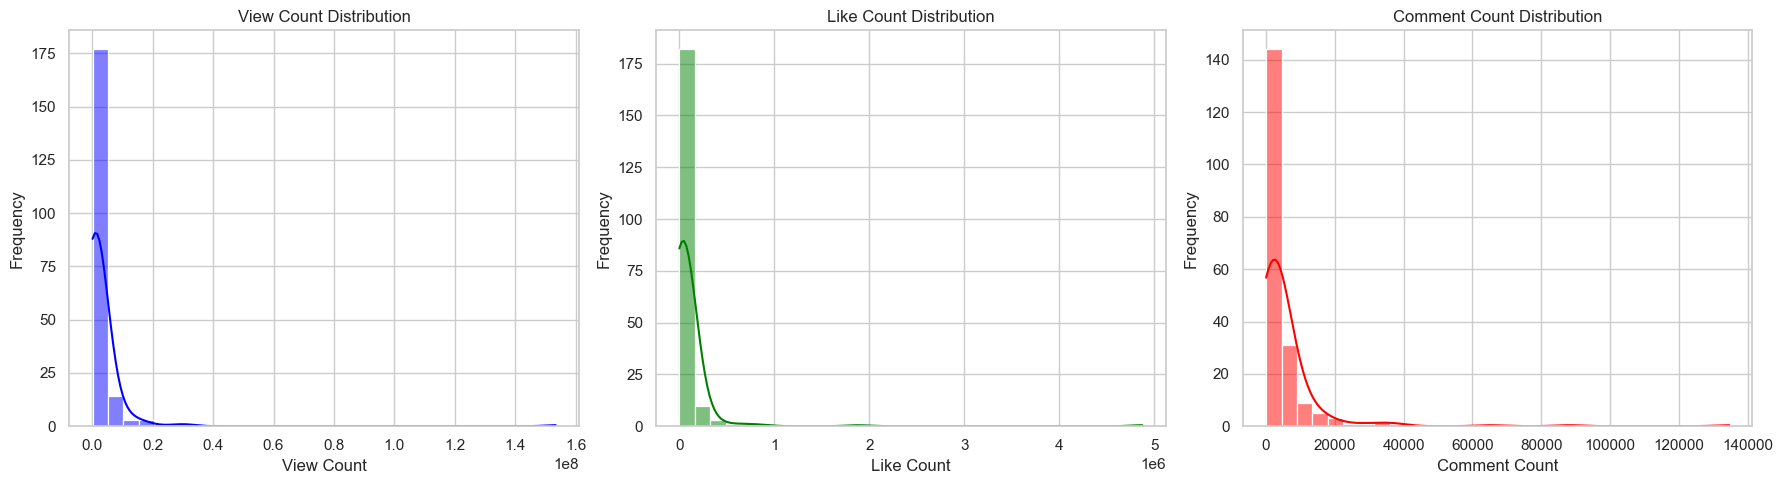

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# view count distribution
sns.histplot(trending_videos['view_count'], bins=30, kde=True, ax=axes[0], color='blue')
axes[0].set_title('View Count Distribution')
axes[0].set_xlabel('View Count')
axes[0].set_ylabel('Frequency')

# like count distribution
sns.histplot(trending_videos['like_count'], bins=30, kde=True, ax=axes[1], color='green')
axes[1].set_title('Like Count Distribution')
axes[1].set_xlabel('Like Count')
axes[1].set_ylabel('Frequency')

# comment count distribution
sns.histplot(trending_videos['comment_count'], bins=30, kde=True, ax=axes[2], color='red')
axes[2].set_title('Comment Count Distribution')
axes[2].set_xlabel('Comment Count')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


The histograms show that the distributions of view counts, like counts, and comment counts are right-skewed, with most videos having lower counts and a few videos having very high counts. Now, let's have a look at the correlation between likes, views, and comments:

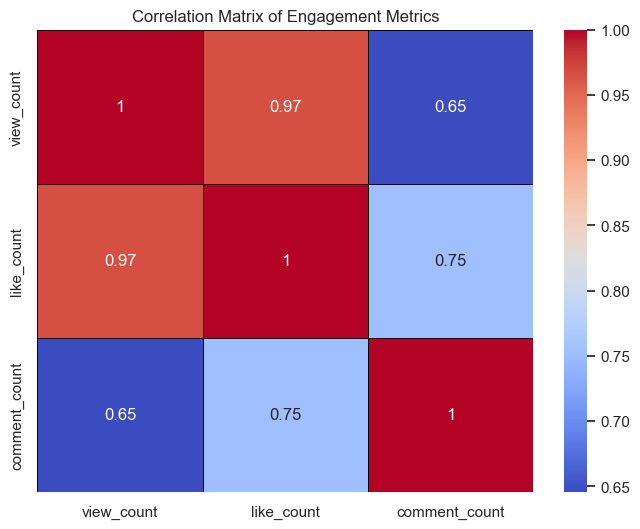

In [10]:
# correlation matrix

correlation_matrix = trending_videos[['view_count', 'like_count', 'comment_count']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, linecolor='black')
plt.title('Correlation Matrix of Engagement Metrics')
plt.show()

The heatmap confirms strong positive correlations between views, likes, and comments

I noticed that I only collected the category ID of the video and not the category name. So, let's collect the category names as well to analyze the categories of the trending videos:

In [11]:
from googleapiclient.discovery import build
API_KEY = 'YOUR API KEY'
youtube = build('youtube', 'v3', developerKey=API_KEY)

def get_category_mapping():
    request = youtube.videoCategories().list(
        part='snippet',
        regionCode='US'
    )
    response = request.execute()
    category_mapping = {}
    for item in response['items']:
        category_id = int(item['id'])
        category_name = item['snippet']['title']
        category_mapping[category_id] = category_name
    return category_mapping

# get the category mapping
category_mapping = get_category_mapping()
print(category_mapping)

{1: 'Film & Animation', 2: 'Autos & Vehicles', 10: 'Music', 15: 'Pets & Animals', 17: 'Sports', 18: 'Short Movies', 19: 'Travel & Events', 20: 'Gaming', 21: 'Videoblogging', 22: 'People & Blogs', 23: 'Comedy', 24: 'Entertainment', 25: 'News & Politics', 26: 'Howto & Style', 27: 'Education', 28: 'Science & Technology', 29: 'Nonprofits & Activism', 30: 'Movies', 31: 'Anime/Animation', 32: 'Action/Adventure', 33: 'Classics', 34: 'Comedy', 35: 'Documentary', 36: 'Drama', 37: 'Family', 38: 'Foreign', 39: 'Horror', 40: 'Sci-Fi/Fantasy', 41: 'Thriller', 42: 'Shorts', 43: 'Shows', 44: 'Trailers'}


Now, here's how we can analyze the number of treding videos by category:

C:\Users\T14\AppData\Local\Temp\ipykernel_1360\1211282388.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=trending_videos['category_name'], order=trending_videos['category_name'].value_counts().index, palette='viridis')


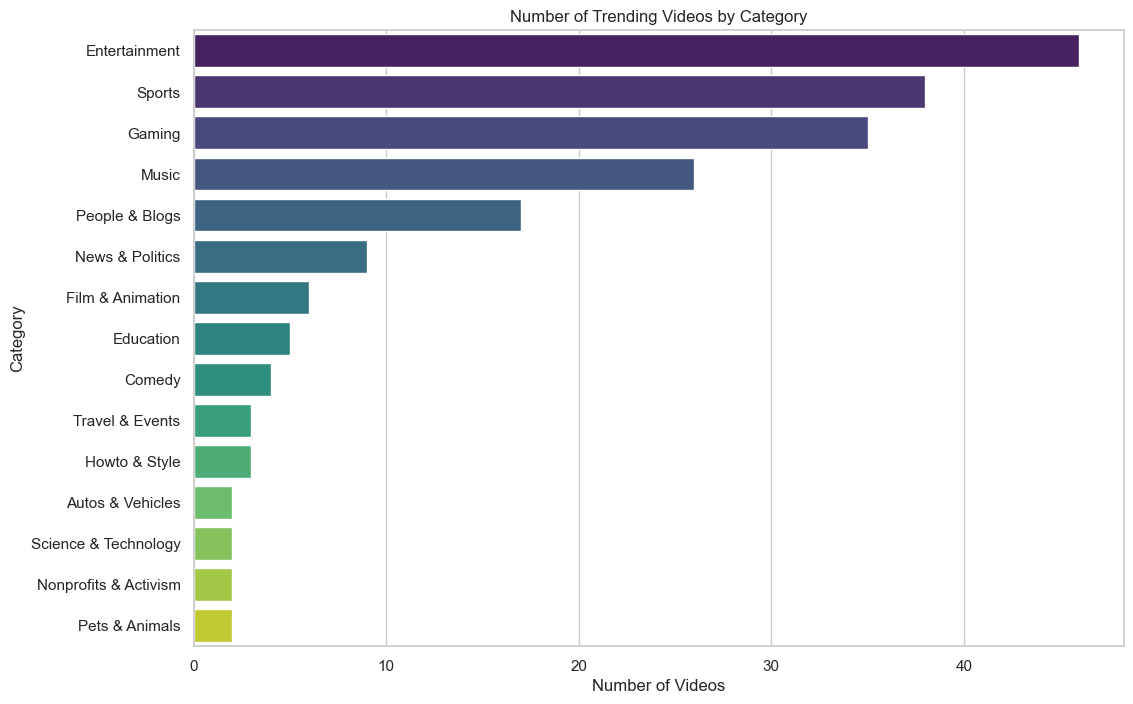

In [12]:
trending_videos['category_name'] = trending_videos['category_id'].map(category_mapping)

# Bar chart for category counts
plt.figure(figsize=(12, 8))
sns.countplot(y=trending_videos['category_name'], order=trending_videos['category_name'].value_counts().index, palette='viridis')
plt.title('Number of Trending Videos by Category')
plt.xlabel('Number of Videos')
plt.ylabel('Category')
plt.show()

The bar chart shows that the Gaming, Entertainment, Sports, and Music categories have the highest number of trending videos. Now, let's have a look at the average engagement metrics by category:

C:\Users\T14\AppData\Local\Temp\ipykernel_1360\4266797331.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=category_engagement.index, x= category_engagement['view_count'], ax=axes[0], palette='viridis')
C:\Users\T14\AppData\Local\Temp\ipykernel_1360\4266797331.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=category_engagement.index, x= category_engagement['like_count'], ax=axes[1], palette='viridis')
C:\Users\T14\AppData\Local\Temp\ipykernel_1360\4266797331.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=category_engageme

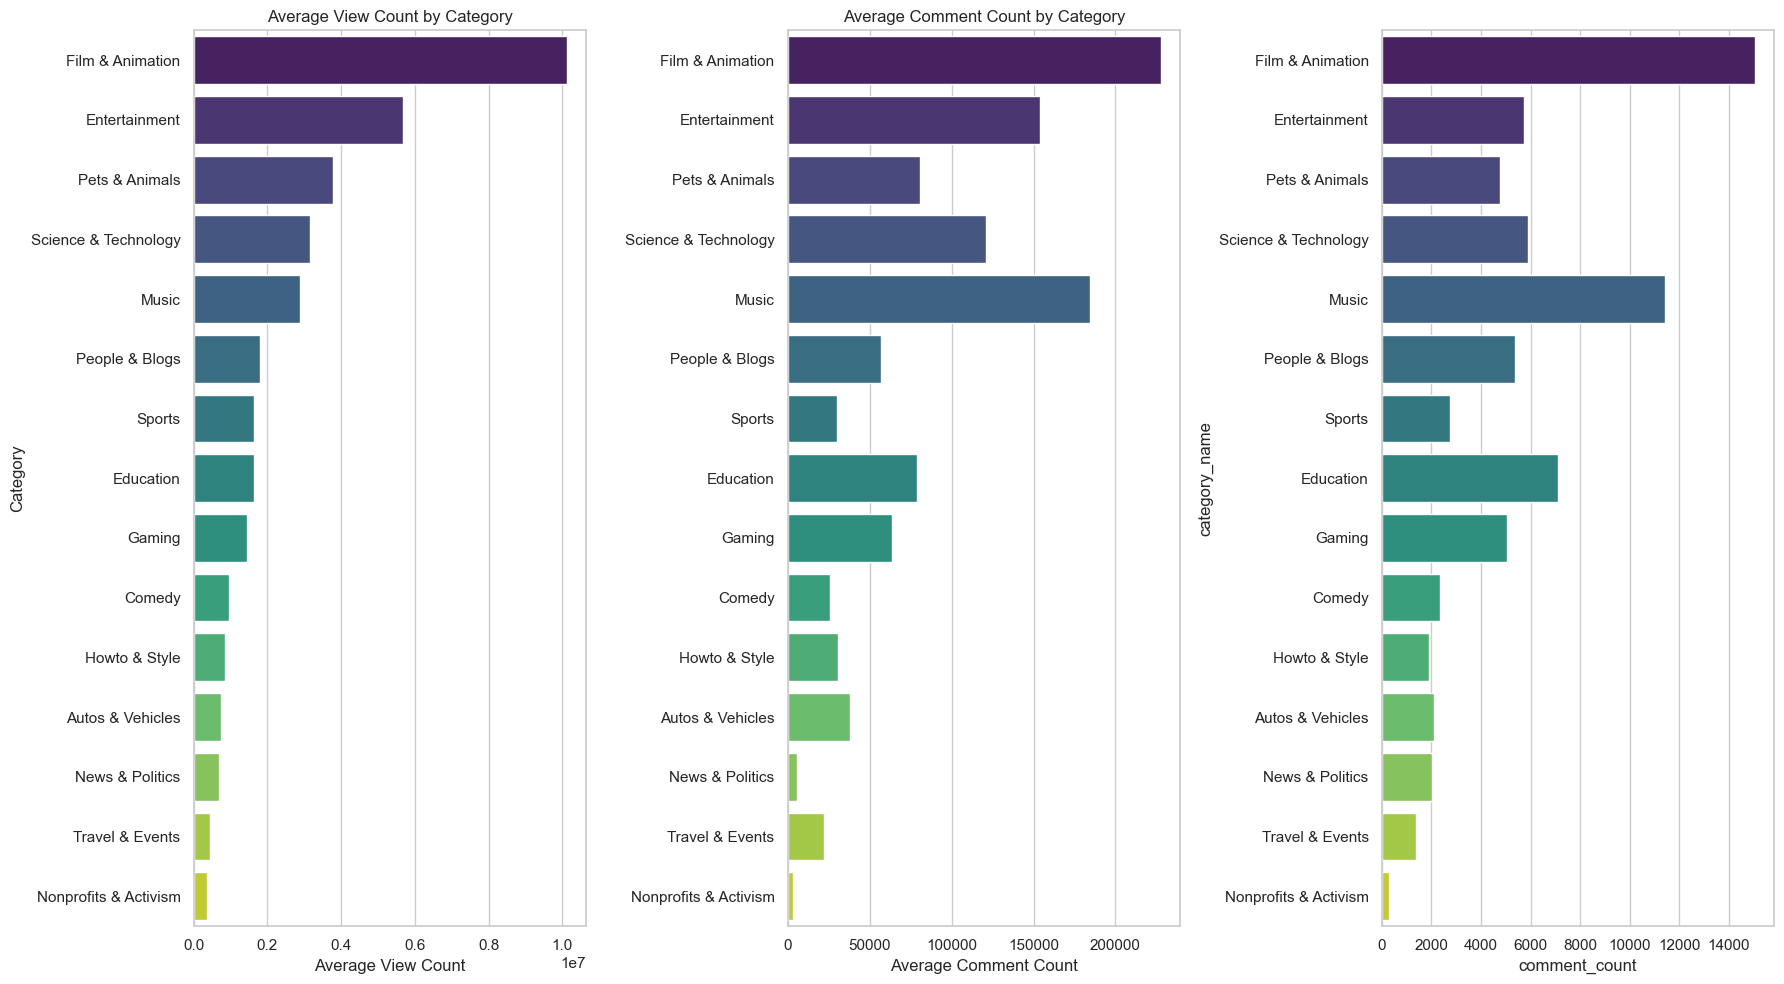

In [13]:
# average engagement metrics by category
category_engagement  = trending_videos.groupby('category_name')[['view_count', 'like_count', 'comment_count']].mean().sort_values(by='view_count', ascending=False)

fig, axes= plt.subplots(1, 3, figsize=(18, 10))

# view count by category
sns.barplot(y=category_engagement.index, x= category_engagement['view_count'], ax=axes[0], palette='viridis')
axes[0].set_title('Average View Count by Category')
axes[0].set_xlabel('Average View Count')
axes[0].set_ylabel('Category')


# like count by category
sns.barplot(y=category_engagement.index, x= category_engagement['like_count'], ax=axes[1], palette='viridis')
axes[1].set_title('Average Like Count by Category')
axes[1].set_xlabel('Average Like Count')
axes[1].set_ylabel('')


# comment count by category
sns.barplot(y=category_engagement.index, x= category_engagement['comment_count'], ax=axes[2], palette='viridis')
axes[1].set_title('Average Comment Count by Category')
axes[1].set_xlabel('Average Comment Count')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()


Music and People & Blogs categories have the highest average view counts, likes, and comments. Film & Animation also shows high engagement, especially in view counts and like counts.

Now, let's analyze the content and durantion of the videos. But first, we need to convert the duration from ISO 8601 format to seconds

In [14]:
import isodate

# convert ISO 8601 duration to seconds
trending_videos['duration_seconds'] = trending_videos['duration'].apply(lambda x: isodate.parse_duration(x).total_seconds())

trending_videos['durantion_range'] = pd.cut(trending_videos['duration_seconds'], bins=[0, 300, 600, 1200, 3600, 7200], labels=['0-5 min', '5-10 min', '10-20 min', '20-60 min', '60-120 min'])


In the above code, we are using the isodate library to convert the duration of each video from the ISO 8601 format to seconds, which allows for numerical analysis. After converting the durations, we are categorizing the videos into different duration ranges (0-5 minutes, 5-10 minutes, 10-20 minutes, 20-60 minutes, and 60-120 minutes) by creating a new column called duration_range. This categorization enables us to analyze and compare the engagement metrics of videos within specific length intervals, providing insights into how video length influences viewer behaviour and video performance

Now, let's analyze the content and the duration of videos

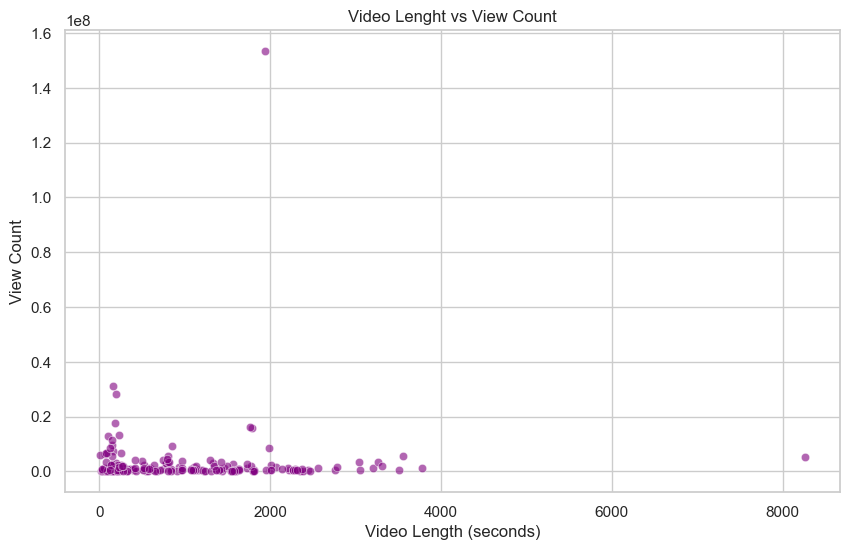

C:\Users\T14\AppData\Local\Temp\ipykernel_1360\1971519225.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  length_engagement = trending_videos.groupby('durantion_range')[['view_count', 'like_count', 'comment_count']].mean()
C:\Users\T14\AppData\Local\Temp\ipykernel_1360\1971519225.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=length_engagement.index, x=length_engagement['view_count'], ax=axes[0], palette='magma')
C:\Users\T14\AppData\Local\Temp\ipykernel_1360\1971519225.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` f

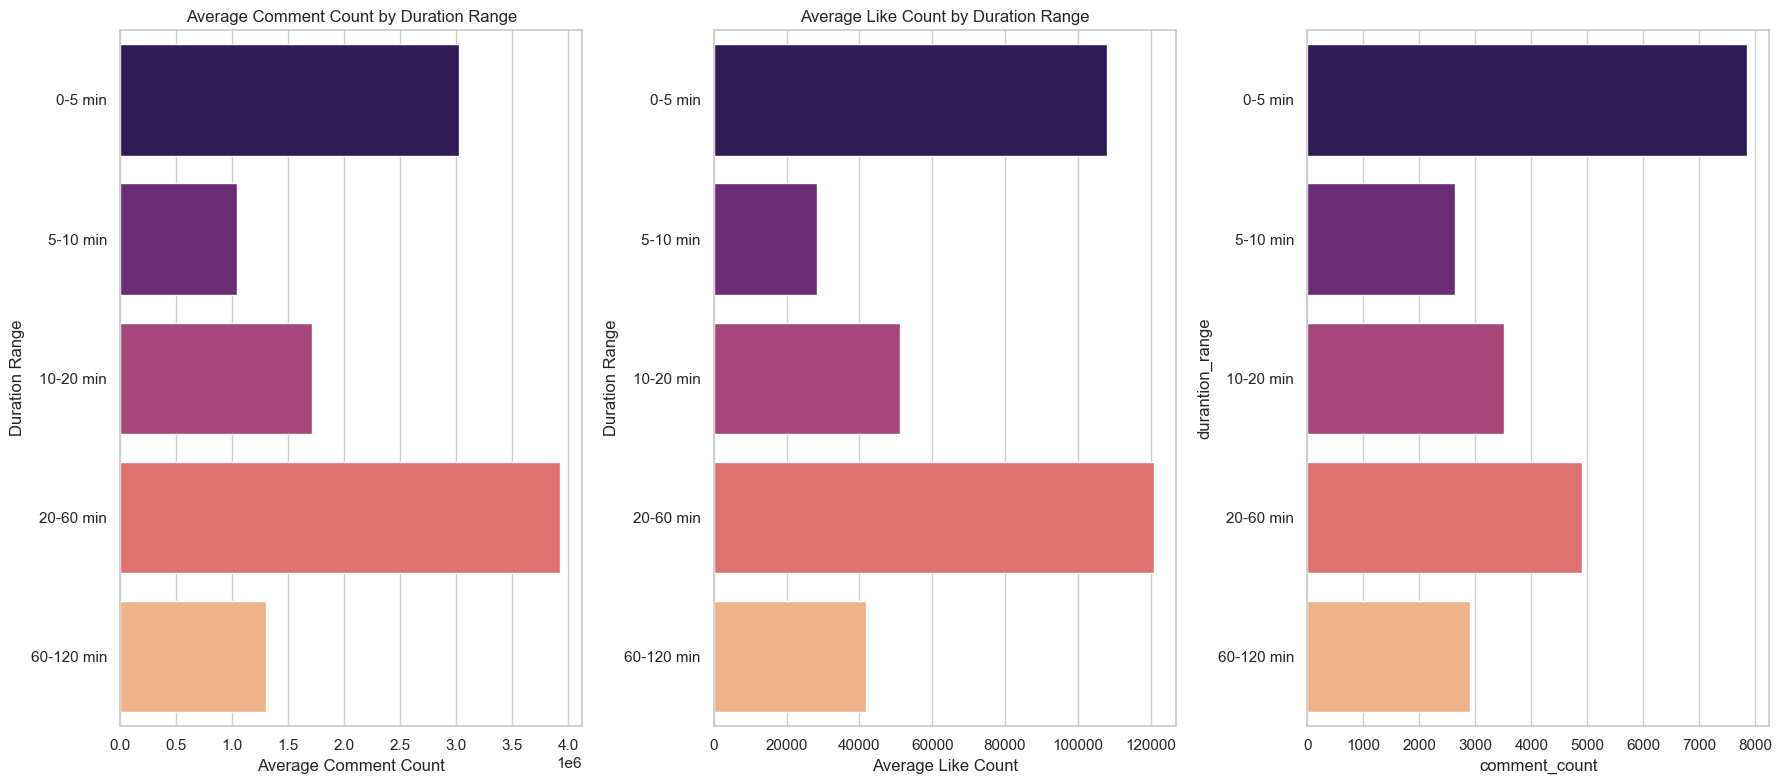

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# scatter plot for video length vs view count
plt.figure(figsize=(10, 6))
sns.scatterplot(x='duration_seconds', y='view_count', data=trending_videos, alpha=0.6, color='purple')
plt.title('Video Lenght vs View Count')
plt.xlabel('Video Length (seconds)')
plt.ylabel('View Count')
plt.show()

# bar chart for engagement metrics by duration range
length_engagement = trending_videos.groupby('durantion_range')[['view_count', 'like_count', 'comment_count']].mean()


fig, axes = plt.subplots(1,3, figsize=(18, 8))

# view count by duration range
sns.barplot(y=length_engagement.index, x=length_engagement['view_count'], ax=axes[0], palette='magma')
axes[0].set_title('Average View Count by Duration Range')
axes[0].set_xlabel('Average View Count')
axes[0].set_ylabel('Duration Range')

# like count by duration range
sns.barplot(y=length_engagement.index, x=length_engagement['like_count'], ax=axes[1], palette='magma')
axes[1].set_title('Average Like Count by Duration Range')
axes[1].set_xlabel('Average Like Count')
axes[1].set_ylabel('Duration Range')


# comment count by duration range
sns.barplot(y=length_engagement.index, x=length_engagement['comment_count'], ax=axes[2], palette='magma')
axes[0].set_title('Average Comment Count by Duration Range')
axes[0].set_xlabel('Average Comment Count')
axes[0].set_ylabel('Duration Range')


plt.tight_layout()
plt.show()


In [18]:
trending_videos.columns

Index(['video_id', 'title', 'description', 'published_at', 'channel_id',
       'channel_title', 'category_id', 'tags', 'duration', 'definition',
       'caption', 'view_count', 'like_count', 'dislike_count',
       'favorite_count', 'comment_count', 'category_name', 'duration_seconds',
       'durantion_range'],
      dtype='object')

The scatter plot shows a sligth negative correlation between video length and view count, indicating shorter videos tend to have higher view counts. Videos in the 0-5 minutes range have the highest average view counts, likes, and comments. Engagement decreases as video length increases

Now, let's analyze the relationship between views and number of tags used in the video

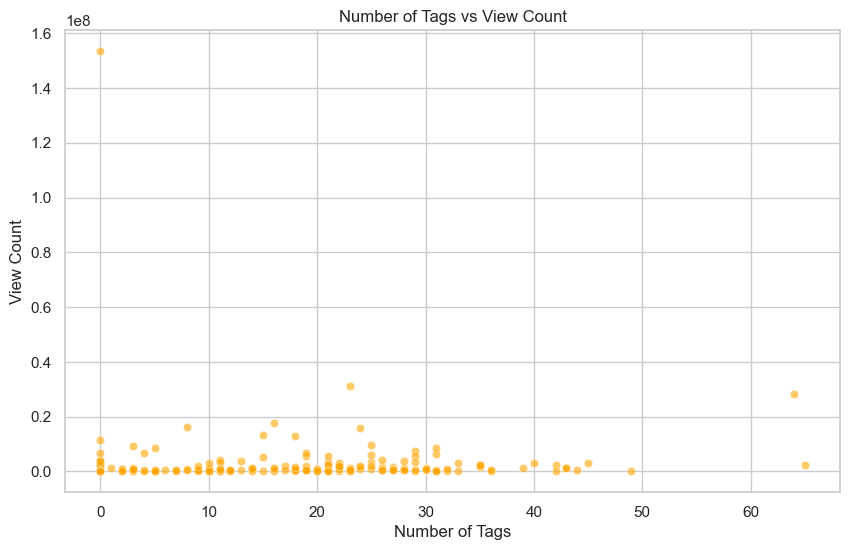

In [20]:
# calculate the number of tags for each video
trending_videos['tag_count'] = trending_videos['tags'].apply(len)

# scatter plot for number of tags vs view count
plt.figure(figsize=(10, 6))
sns.scatterplot(x='tag_count', y='view_count', data=trending_videos, alpha=0.6, color='orange')
plt.title('Number of Tags vs View Count')
plt.xlabel('Number of Tags')
plt.ylabel('View Count')
plt.show()

The scatter plot shows a very weak relationship between the number of tags and view count, suggesting that the number of tags has minimal impact on a video's view count.

Now, let's see if there's an impact of the time a video is posted on its views:


C:\Users\T14\AppData\Local\Temp\ipykernel_1360\1346126130.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='publish_hour', data=trending_videos, palette='coolwarm')


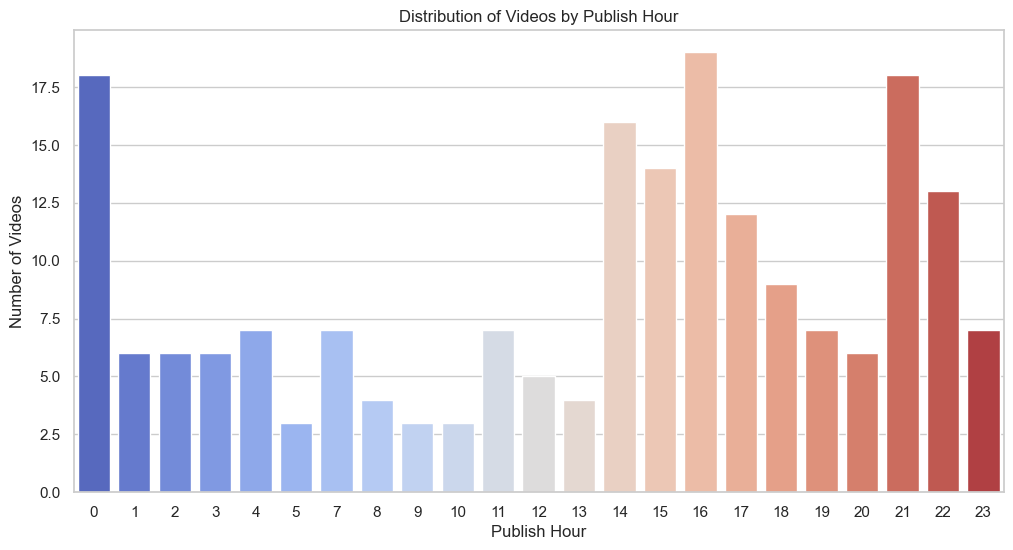

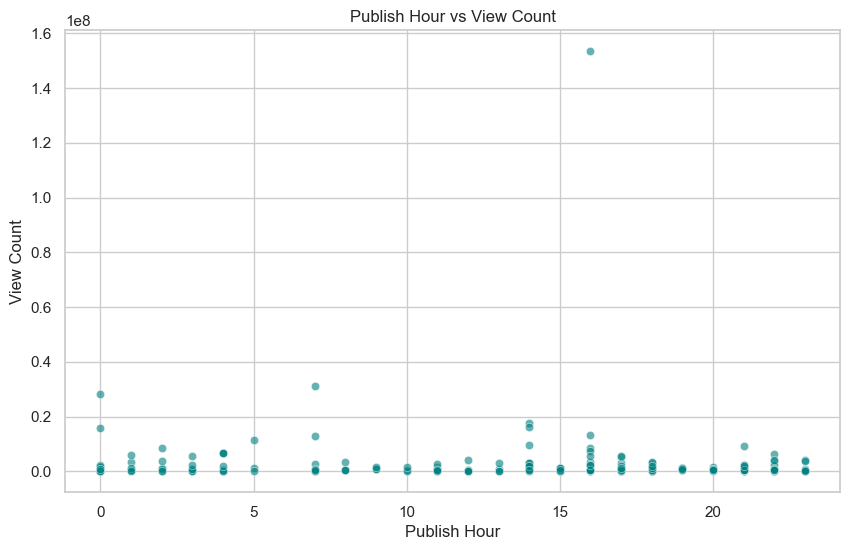

In [21]:
# extract hour of publication
trending_videos['publish_hour'] = trending_videos['published_at'].dt.hour

# bar chart for publish hour distribution
plt.figure(figsize=(12, 6))
sns.countplot(x='publish_hour', data=trending_videos, palette='coolwarm')
plt.title('Distribution of Videos by Publish Hour')
plt.xlabel('Publish Hour')
plt.ylabel('Number of Videos')
plt.show()


# bar chart for publish hour distribution
plt.figure(figsize=(10, 6))
sns.scatterplot(x='publish_hour', y='view_count', data=trending_videos,alpha=0.6, color='teal')
plt.title('Publish Hour vs View Count')
plt.xlabel('Publish Hour')
plt.ylabel('View Count')
plt.show()

The distribution shows that most videos are published between 14:00 and 20:00 hours (2PM - 8PM), indicating this may be an optimal time for uploading videos. There is a very weak negative relationship between publish hour and view count, suggesting that the hour of publication has minimal impact on engagement